In [16]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, normalize , MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, TruncatedSVD
import umap
from sklearn.datasets import fetch_lfw_people
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, plot_confusion_matrix
import lightgbm as lgbm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
import spacy
nltk.download('wordnet')

## 1: Face Recognition, but not evil this time

Using the faces dataset in:

```
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
```

If you use the `faces.target` and `faces.target_names` attributes, you can build a facial recognition algorithm.

Use sklearn **gridsearch** (or an equivalent, like random search) to optimize the model for accuracy. Try both a SVM-based classifier and a logistic regression based classifier (with a feature pipeline of your choice) to get the best model. You should have at least 80% accuracy.

In [2]:
faces = fetch_lfw_people(min_faces_per_person = 60)

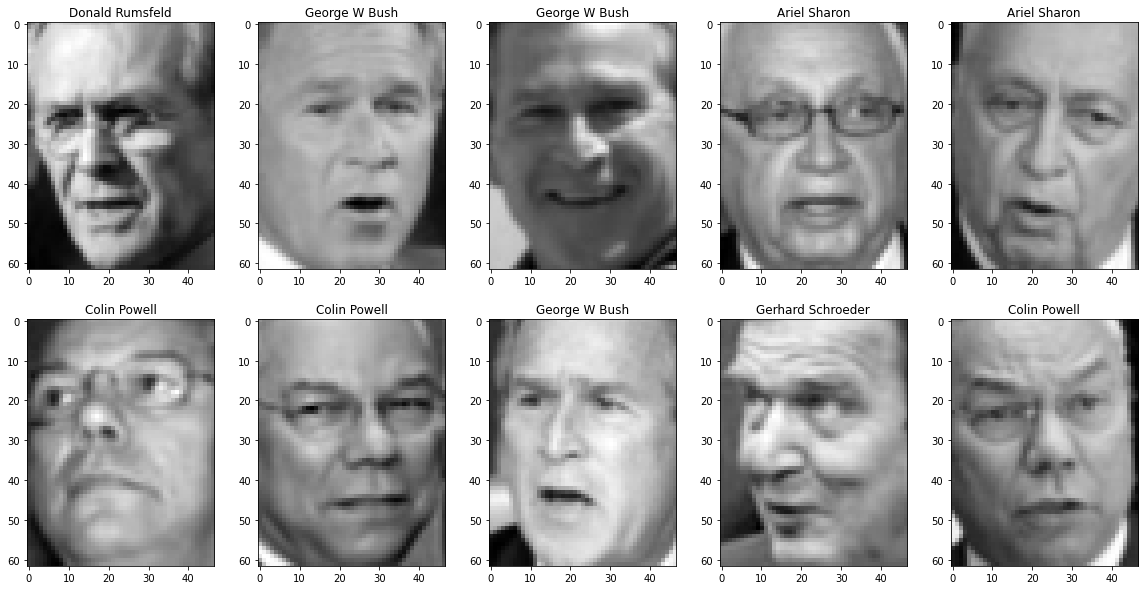

In [3]:
N_IMG = 10
N_ROWS = 2
N_COLS = 5

d = dict(zip(range(7), faces.target_names))

imgs = faces.images[:N_IMG]
target_names = np.array(pd.Series(faces.target[:N_IMG]).map(d))
imgs = np.array(imgs).reshape(N_ROWS, N_COLS, 62, 47)
target_names = target_names.reshape(N_ROWS, N_COLS)
fig, axs = plt.subplots(N_ROWS, N_COLS, figsize = (20,10))

for r in range(N_ROWS):
    for c in range(N_COLS):
        axs[r,c].imshow(imgs[r,c], cmap= 'gray')
        axs[r,c].set_title(target_names[r,c])
        
plt.show()

In [4]:
X = faces.data
y = faces.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
#Logistic Regression
model = LogisticRegression()
param_grid = {'solver' : ['saga'], 'max_iter' : [1000]}#'penalty' : ['elasticnet'], 'l1_ratio' : [0,0.5,1], 
clf = GridSearchCV(estimator = model, param_grid = param_grid, scoring = 'accuracy', cv = 2)
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_test_pred)
accuracy

0.8307291666666666

In [6]:
#SVM
model = svm.LinearSVC(max_iter=30000)
param_grid = {'C' : [60]}
model = GridSearchCV(model, param_grid = param_grid, scoring = 'accuracy', cv=3)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_test_pred)
accuracy

0.8229166666666666

In [7]:
#model RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
param_grid = {'n_estimators':[100,250,300],
              'max_features' : ['auto'],
              'max_depth' : [int(x) for x in np.linspace(10, 110, num = 3)]}
model = GridSearchCV(model, param_grid = param_grid, cv = 3)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_test_pred)
accuracy

0.640625

# 2: Bag of Words, Bag of Popcorn

By this point, you are ready for the [Bag of Words, Bag of Popcorn](https://www.kaggle.com/c/word2vec-nlp-tutorial/data) competition. 

Use NLP feature pre-processing (using, SKLearn, Gensim, Spacy or Hugginface) to build the best classifier you can. Use a  feature pipeline, and gridsearch for your final model.

A succesful project should get 80% or more on a **holdout** dataset you kept for yourself.

In [ ]:
#Boosted model accuracy with help from Martin

In [8]:
df_train = pd.read_csv('labeledTrainData.tsv', header=0, delimiter="\t", quoting=3)
df_train

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."
...,...,...,...
24995,"""3453_3""",0,"""It seems like more consideration has gone int..."
24996,"""5064_1""",0,"""I don't believe they made this film. Complete..."
24997,"""10905_3""",0,"""Guy is a loser. Can't get girls, needs to bui..."
24998,"""10194_3""",0,"""This 30 minute documentary Buñuel made in the..."


In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         25000 non-null  object
 1   sentiment  25000 non-null  int64 
 2   review     25000 non-null  object
dtypes: int64(1), object(2)
memory usage: 586.1+ KB


In [10]:
#Sample review
df_train.iloc[0]['review']

'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally

In [11]:
nlp = spacy.load('en_core_web_sm')


In [12]:
text = df_train.iloc[0]['review']
soup = BeautifulSoup(text, 'html.parser').get_text()


In [13]:
reviews = df_train.copy()

#Clean html tags with beautifulsoup
def remove_tags(r):
    soup = BeautifulSoup(r, 'html.parser')
    text = soup.get_text()
    return text

def letters_only(r):
    return re.sub("[^a-zA-Z]", " ", r)

def get_lemma(r):
    
#     lemmatizer = WordNetLemmatizer()
#     tokenized_review = word_tokenize(r)
#     lemmatized_tokens= [lemmatizer.lemmatize(t) for t in tokenized_review]
#     return ' '.join(lemmatized_tokens)
    r=nlp(r)
    lemmas = []
    for token in r:
        lemmas.append(token.lemma_)
    return ' '.join(lemmas)
        
reviews['review'] = (reviews['review'].apply(remove_tags)
                                      .apply(letters_only)
                                      .apply(get_lemma)
                    )

X = reviews['review']
y = reviews['sentiment']

In [14]:
def get_model_results(X,y, model_name, model):
    X = X.copy()
    y = y.copy()
    
    vectorizer = TfidfVectorizer(lowercase = True,
                                stop_words = 'english',
                                max_df = 0.98,
                                min_df = 2
                                )
#     scaler = StandardScaler(with_mean=False)
    clf = model
    pipe = Pipeline([('vec', vectorizer), ('clf', clf )]) #, ('scaler', scaler)

    if model_name == 'LogisticRegression':
        param_grid = {
            'clf__solver' : ['saga'],
            'clf__max_iter' : [2000]
        }
    elif model_name == 'KneighborsClassifier':
        param_grid = {
            'clf__n_neighbors' : [6,7],
            'clf__n_jobs': [-1]
        }
        
    elif model_name == 'RandomForestClassifier':
        param_grid = {
            'clf__n_estimators': [1750]
        }
    else: 
        param_grid = {}
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    search = GridSearchCV(pipe, param_grid, scoring = 'accuracy', n_jobs = -1)
    search.fit(X_train, y_train)

    y_train_predict = search.predict(X_train)
    y_test_predict = search.predict(X_test)
    
    print(f'model: {model} \nbest parameters: {search.best_params_}')
    
    print(f'\nResults for training data')
    print(classification_report(y_train, y_train_predict))
    print(f'Results for testing data')    
    print(classification_report(y_test, y_test_predict))

    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20, 10))
    plot_confusion_matrix(search, X_train, y_train, ax = ax1)
    ax1.set_title(f'Confusion Matrix Generated\n with {name} Model and Training Data')
    plot_confusion_matrix(search, X_test, y_test, ax = ax2)
    ax2.set_title(f'Confusion Matrix Generated\n with {name} Model and Testing Data')
    plt.show()


model: LogisticRegression() 
best parameters: {'clf__max_iter': 2000, 'clf__solver': 'saga'}

Results for training data
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      8395
           1       0.92      0.94      0.93      8355

    accuracy                           0.93     16750
   macro avg       0.93      0.93      0.93     16750
weighted avg       0.93      0.93      0.93     16750

Results for testing data
              precision    recall  f1-score   support

           0       0.90      0.87      0.88      4105
           1       0.87      0.90      0.89      4145

    accuracy                           0.88      8250
   macro avg       0.88      0.88      0.88      8250
weighted avg       0.88      0.88      0.88      8250



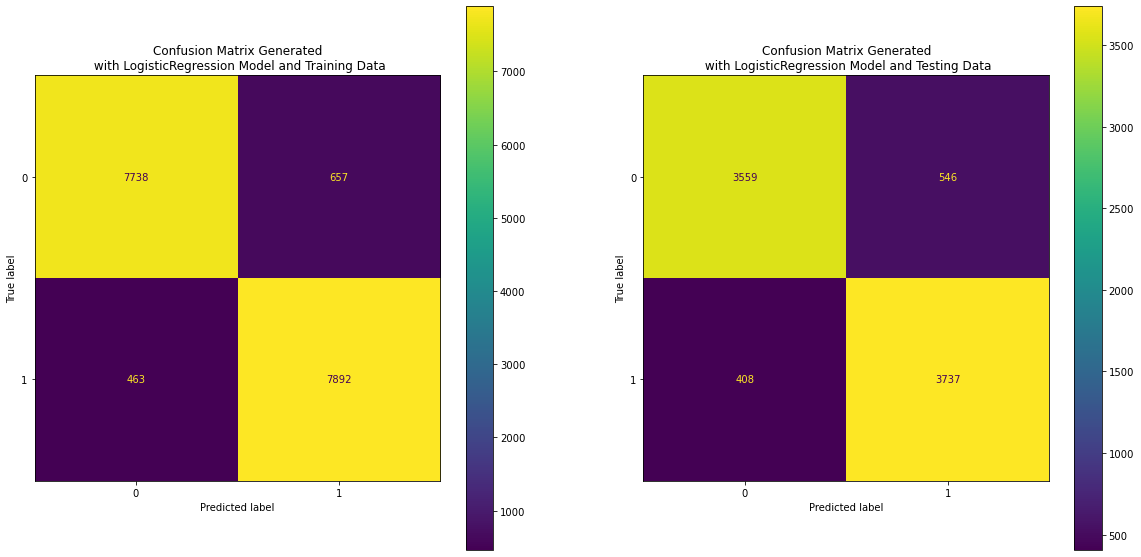

model: KNeighborsClassifier() 
best parameters: {'clf__n_jobs': -1, 'clf__n_neighbors': 7}

Results for training data
              precision    recall  f1-score   support

           0       0.88      0.80      0.84      8395
           1       0.81      0.89      0.85      8355

    accuracy                           0.84     16750
   macro avg       0.85      0.84      0.84     16750
weighted avg       0.85      0.84      0.84     16750

Results for testing data
              precision    recall  f1-score   support

           0       0.82      0.73      0.77      4105
           1       0.76      0.84      0.80      4145

    accuracy                           0.78      8250
   macro avg       0.79      0.78      0.78      8250
weighted avg       0.79      0.78      0.78      8250



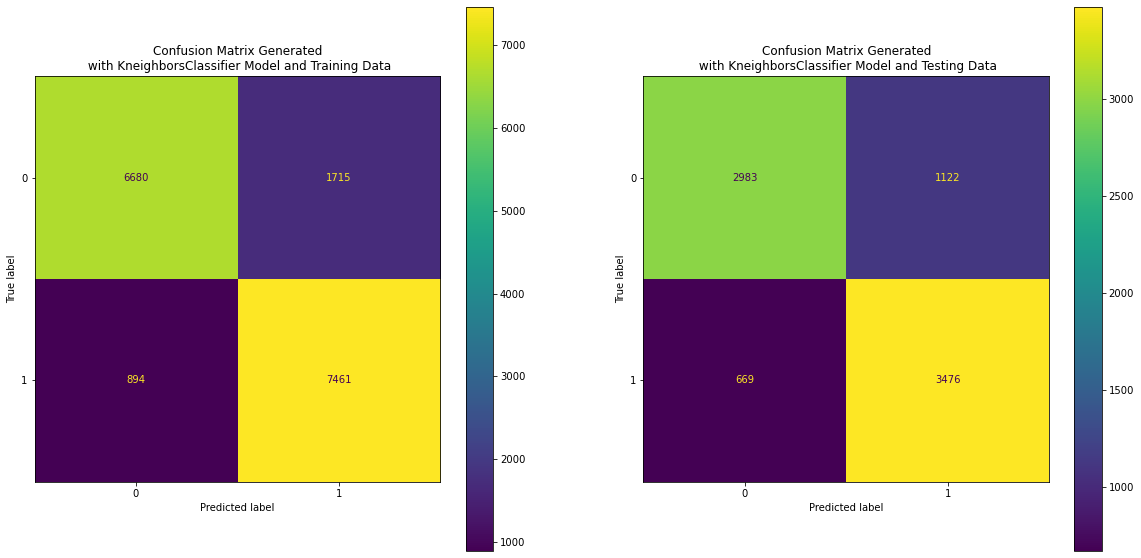

model: BernoulliNB() 
best parameters: {}

Results for training data
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      8395
           1       0.93      0.85      0.89      8355

    accuracy                           0.89     16750
   macro avg       0.89      0.89      0.89     16750
weighted avg       0.89      0.89      0.89     16750

Results for testing data
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      4105
           1       0.87      0.80      0.84      4145

    accuracy                           0.84      8250
   macro avg       0.84      0.84      0.84      8250
weighted avg       0.84      0.84      0.84      8250



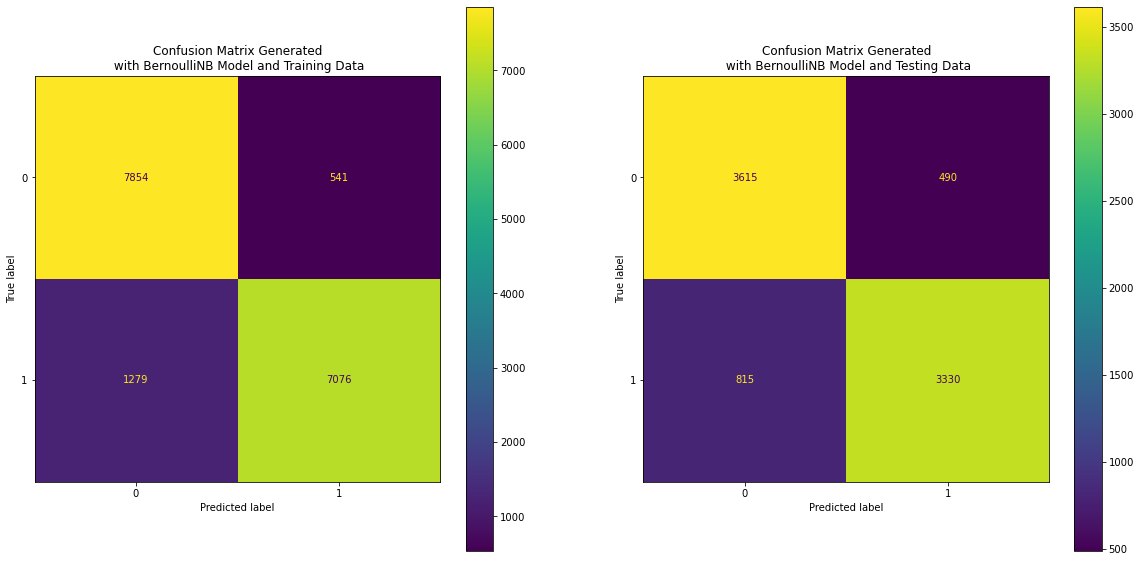

model: LinearSVC() 
best parameters: {}

Results for training data
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8395
           1       0.99      0.99      0.99      8355

    accuracy                           0.99     16750
   macro avg       0.99      0.99      0.99     16750
weighted avg       0.99      0.99      0.99     16750

Results for testing data
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      4105
           1       0.88      0.90      0.89      4145

    accuracy                           0.88      8250
   macro avg       0.88      0.88      0.88      8250
weighted avg       0.88      0.88      0.88      8250



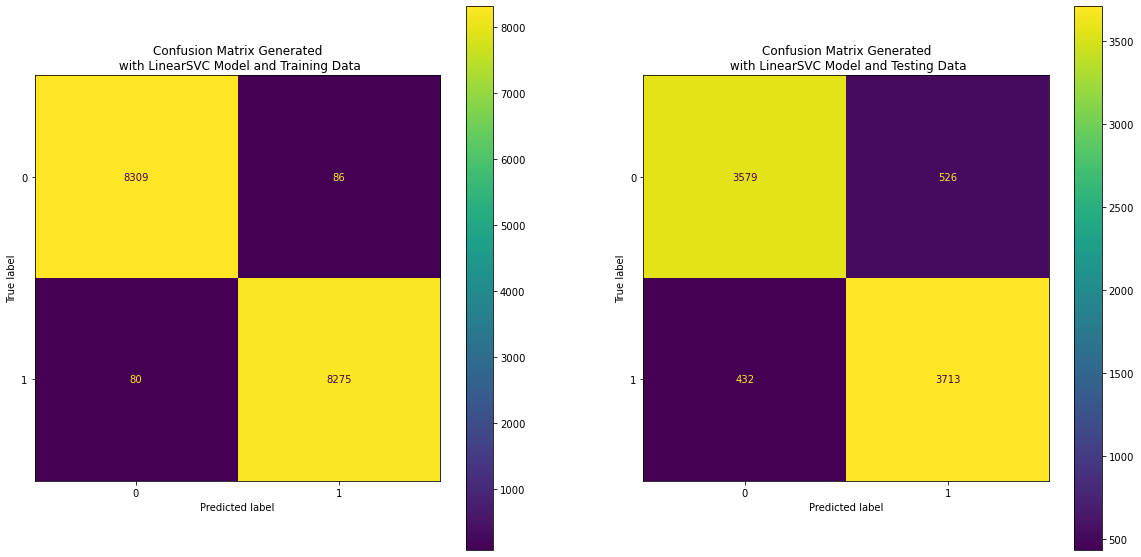

model: RandomForestClassifier() 
best parameters: {'clf__n_estimators': 1750}

Results for training data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8395
           1       1.00      1.00      1.00      8355

    accuracy                           1.00     16750
   macro avg       1.00      1.00      1.00     16750
weighted avg       1.00      1.00      1.00     16750

Results for testing data
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      4105
           1       0.86      0.86      0.86      4145

    accuracy                           0.86      8250
   macro avg       0.86      0.86      0.86      8250
weighted avg       0.86      0.86      0.86      8250



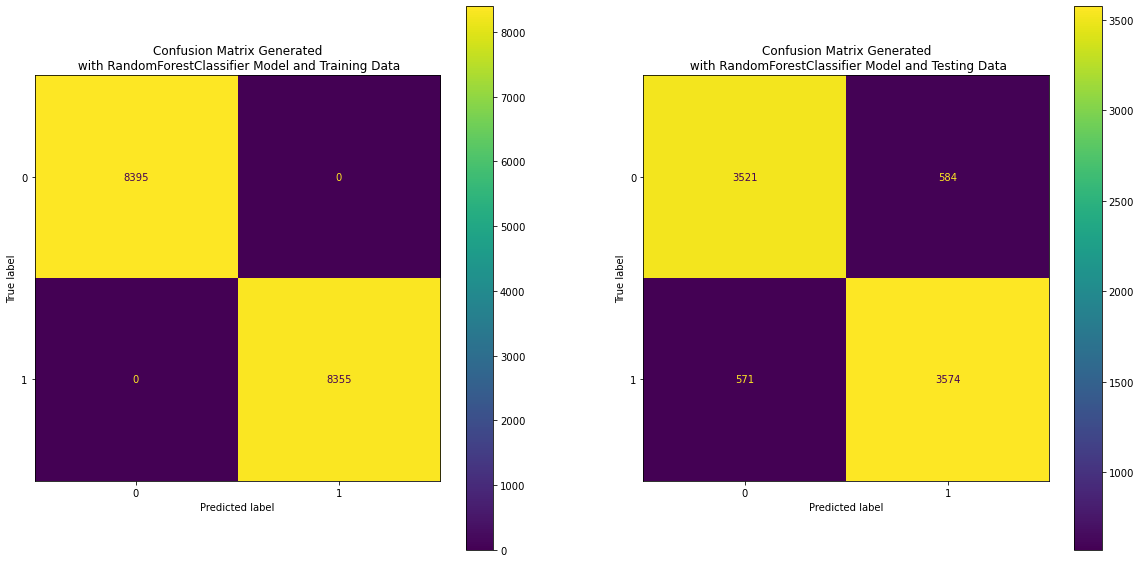

In [15]:
X = X.copy()
y = y.copy()

models = {
    'LogisticRegression': LogisticRegression(),
    'KneighborsClassifier': KNeighborsClassifier(), 
    'BernoulliNB' : BernoulliNB(),
    'LinearSVC' : svm.LinearSVC(),
    'RandomForestClassifier': RandomForestClassifier()
}

for name, model in models.items():
    get_model_results(X, y, name, model)